In [36]:
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

from src.config import TRAIN_ANNOTATIONS_JSON, VAL_ANNOTATIONS_JSON, FIGURES_DIR
from src.dataset import load_category_mappings, create_segmentation_mask


In [37]:
def load_annotations(ann_file):
    with open(ann_file, "r") as f:
        dataset = json.load(f)

    coco = COCO(ann_file)
    category_mappings = load_category_mappings(ann_file)
    image_data = []

    for img in dataset["images"]:
        img_id = img["id"]
        img_pixels = img["height"] * img["width"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = create_segmentation_mask(
            coco, img_id, img["height"], img["width"], category_mappings
        )
        total_foreground_pixels = np.count_nonzero(mask)
        
        for ann in anns:
            cat_id = ann["category_id"]
            cat_name = coco.cats[cat_id]["name"]
            fg_pixels = ann.get("area", 0)

            image_data.append(
                {
                    "image_id": img_id,
                    "image_label": img["file_name"],
                    "category_id": cat_id,
                    "category_name": cat_name,
                    "category_pixels": fg_pixels,
                    "foreground_pixels": total_foreground_pixels,
                    "image_pixels": img_pixels,
                    "fg_area_ratio": fg_pixels / img_pixels if img_pixels > 0 else 0,
                    "total_area_ratio": total_foreground_pixels / img_pixels
                    if img_pixels > 0
                    else 0,
                }
            )

    return pd.DataFrame(image_data)

train_df = load_annotations(TRAIN_ANNOTATIONS_JSON)
val_df = load_annotations(VAL_ANNOTATIONS_JSON)

dataset_df = pd.concat([train_df, val_df], ignore_index=True)

dataset_df.head()

loading annotations into memory...
Done (t=3.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


,image_id,image_label,category_id,category_name,category_pixels,foreground_pixels,image_pixels,fg_area_ratio,total_area_ratio
0,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,23,shoe,21618,143007,1048576,0.020617,0.136382
1,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,23,shoe,25257,143007,1048576,0.024087,0.136382
2,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,7,shorts,96132,143007,1048576,0.091679,0.136382
3,12446,da3618863549ca1db90583f33d1d0664.jpg,14,hat,28104,212154,698368,0.040242,0.303785
4,12446,da3618863549ca1db90583f33d1d0664.jpg,33,neckline,1772,212154,698368,0.002537,0.303785


## Counting the number of images per label

In [38]:
main_item_names = [
    "shirt, blouse",
    "top, t-shirt, sweatshirt",
    "sweater",
    "cardigan",
    "jacket",
    "vest",
    "pants",
    "shorts",
    "skirt",
    "coat",
    "dress",
    "jumpsuit",
    "cape",
    "glasses",
    "hat",
    "headband, head covering, hair accessory",
    "tie",
    "glove",
    "watch",
    "belt",
    "leg warmer",
    "tights, stockings",
    "sock",
    "shoe",
    "bag, wallet",
    "scarf",
    "umbrella",
]

count_df = (
    dataset_df.groupby(["category_id", "category_name"])["image_id"]
    .apply(list)
    .reset_index(name="occurrence")
)

count_df["label_count"] = count_df["occurrence"].apply(len)
count_df["image_count"] = count_df["occurrence"].apply(lambda x: len(set(x)))

count_df = count_df[count_df["category_name"].isin(main_item_names)]

count_df.head()

,category_id,category_name,occurrence,label_count,image_count
0,0,"shirt, blouse","[17264, 17672, 9459, 16375, 9661, 16113, 20165...",6263,6217
1,1,"top, t-shirt, sweatshirt","[12446, 17107, 9459, 9446, 13028, 16265, 19980...",17025,16639
2,2,sweater,"[12069, 19711, 17338, 12970, 10830, 10723, 169...",1515,1506
3,3,cardigan,"[18278, 14772, 17513, 12748, 15584, 13227, 166...",1119,1113
4,4,jacket,"[17672, 9459, 9446, 13028, 9661, 15671, 10431,...",8016,7921


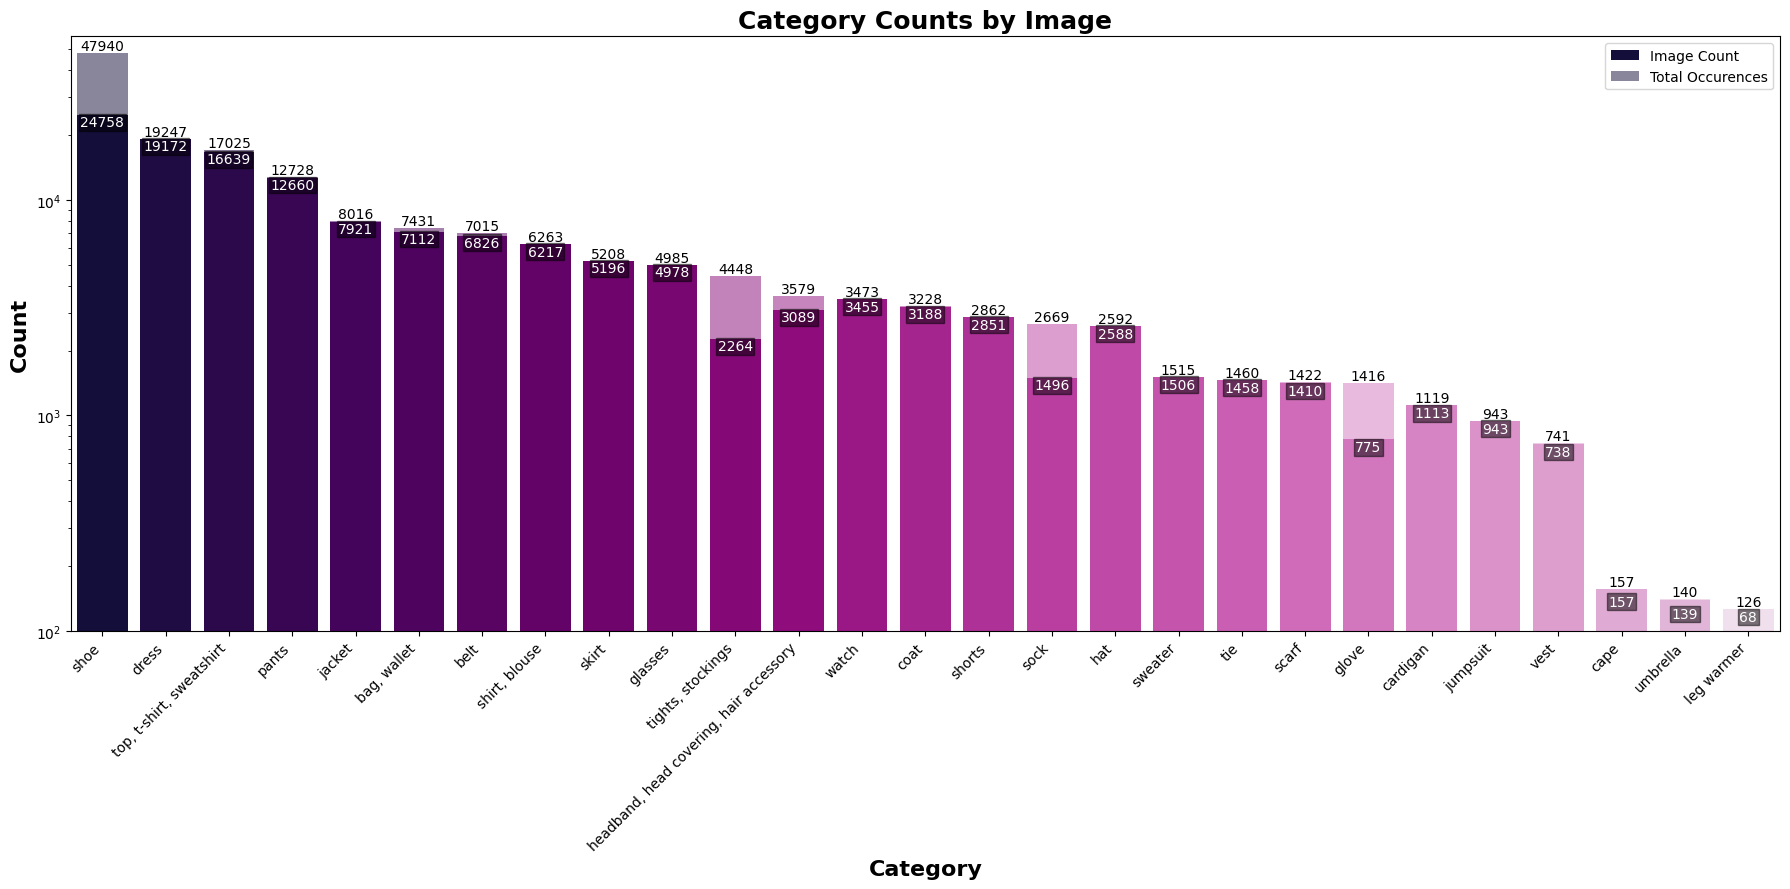

In [43]:
cmap = load_cmap("Flash", cmap_type="continuous", reverse=True)

num_categories = len(count_df)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

sorted_stats = count_df.sort_values("label_count", ascending=False)

plt.figure(figsize=(18, 9))

max_label_count = sorted_stats["label_count"].max()
max_image_count = sorted_stats["image_count"].max()
max_count = max(max_label_count, max_image_count)

plt.ylim(100, max_count * 1.2)

bars1 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["image_count"],
    color=colors,
    label="Image Count",
)

bars2 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["label_count"],
    alpha=0.5,
    color=colors,
    label="Total Occurences",
)

plt.xticks(
    range(len(sorted_stats)), sorted_stats["category_name"], rotation=45, ha="right"
)

plt.xlabel("Category", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.title("Category Counts by Image", fontsize=18, fontweight="bold")

plt.yscale("log")
plt.xlim(-0.5, len(sorted_stats) - 0.5)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        max(height - 10,125),
        f"{int(height)}",
        ha="center",
        va="top",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')
    
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_counts_by_image.png")
plt.show()


### Observations  

The Fashionpedia dataset reveals that certain clothing items are significantly more common than others. Among the most frequently occurring labels, "shoe" appears in 24,758 images, followed by "dress" in 19,172 images and "top, t-shirt, sweatshirt" in 16,639 images. In contrast, some labels, such as "cape," "umbrella," and "leg warmer," are far less prevalent.  

Additionally, many labels appear multiple times within a single image. This pattern is particularly evident for items such as "shoe," "tights, stockings," "sock," "glove," and "leg warmer," as these typically come in pairs. Accessories also frequently appear in multiples within an image, which is expected since outfits often include more than one accessory.  

### Hypothesis  

Based on these observations, we hypothesize the following regarding the performance of our clothing segmentation model:  

- **Higher segmentation accuracy** is expected for **frequent categories** (e.g., shoes, dresses, tops) due to the larger volume of training data available for these items.  
- **Lower segmentation accuracy** may occur for **rare categories** (e.g., capes, umbrellas, leg warmers) due to limited training samples, leading to poor generalization.  
- **Items that appear in multiples within a single image** (e.g., shoes, socks, gloves) may pose a challenge for segmentation, as distinguishing and accurately identifying multiple instances of the same item could be difficult.  
- **Accessory segmentation performance** may vary depending on their size and placement within an image, as small or overlapping accessories could be harder for the model to detect.  


## Mean and Variance for the Pixel Ratio per Category

In [44]:
ratio_df = (
    dataset_df.groupby(["category_id", "category_name"])
    .agg(
        area_ratio_mean=("total_area_ratio", "mean"),
        area_ratio_median=("total_area_ratio", "median"),
        area_ratio_stdev=("total_area_ratio", "std"),
        foreground_area_ratio_mean=("fg_area_ratio", "mean"),
        foreground_area_ratio_median=("fg_area_ratio", "median"),
        foreground_area_ratio_stdev=("fg_area_ratio", "std"),
    )
    .reset_index()
)

ratio_df = ratio_df[ratio_df["category_name"].isin(main_item_names)]

ratio_df.head()

,category_id,category_name,area_ratio_mean,area_ratio_median,area_ratio_stdev,foreground_area_ratio_mean,foreground_area_ratio_median,foreground_area_ratio_stdev
0,0,"shirt, blouse",0.231496,0.190352,0.136098,0.093120,0.035904,0.140768
1,1,"top, t-shirt, sweatshirt",0.210955,0.171301,0.141356,0.106995,0.044971,0.149426
2,2,sweater,0.301068,0.267885,0.174348,0.217322,0.128102,0.207131
3,3,cardigan,0.258307,0.198593,0.175112,0.164625,0.074916,0.198394
4,4,jacket,0.221237,0.181508,0.129053,0.133398,0.083535,0.132275


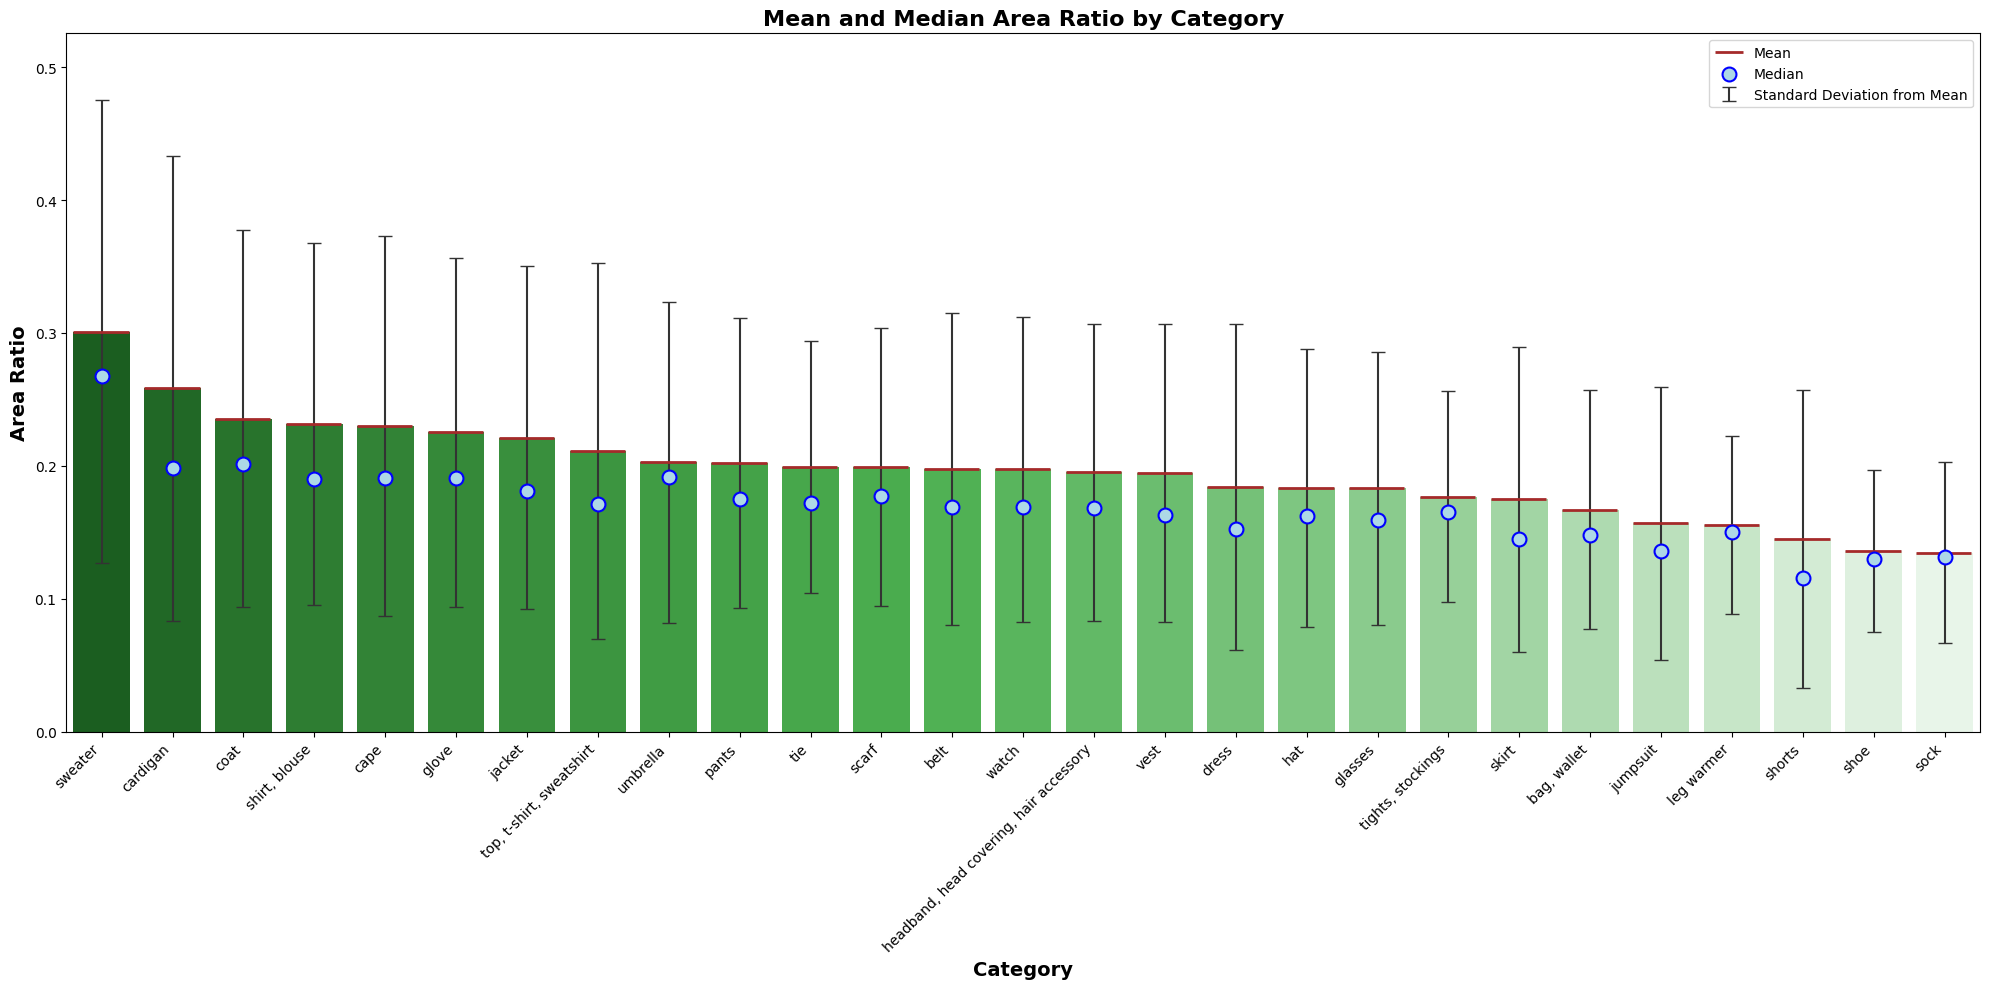

In [45]:
sorted_stats = ratio_df.sort_values("area_ratio_mean", ascending=False)

cmap = load_cmap("green_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8  
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["area_ratio_mean"],
    yerr=sorted_stats["area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["area_ratio_mean"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5) 

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["area_ratio_mean"] + sorted_stats["area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_area_ratio.png")
plt.show()

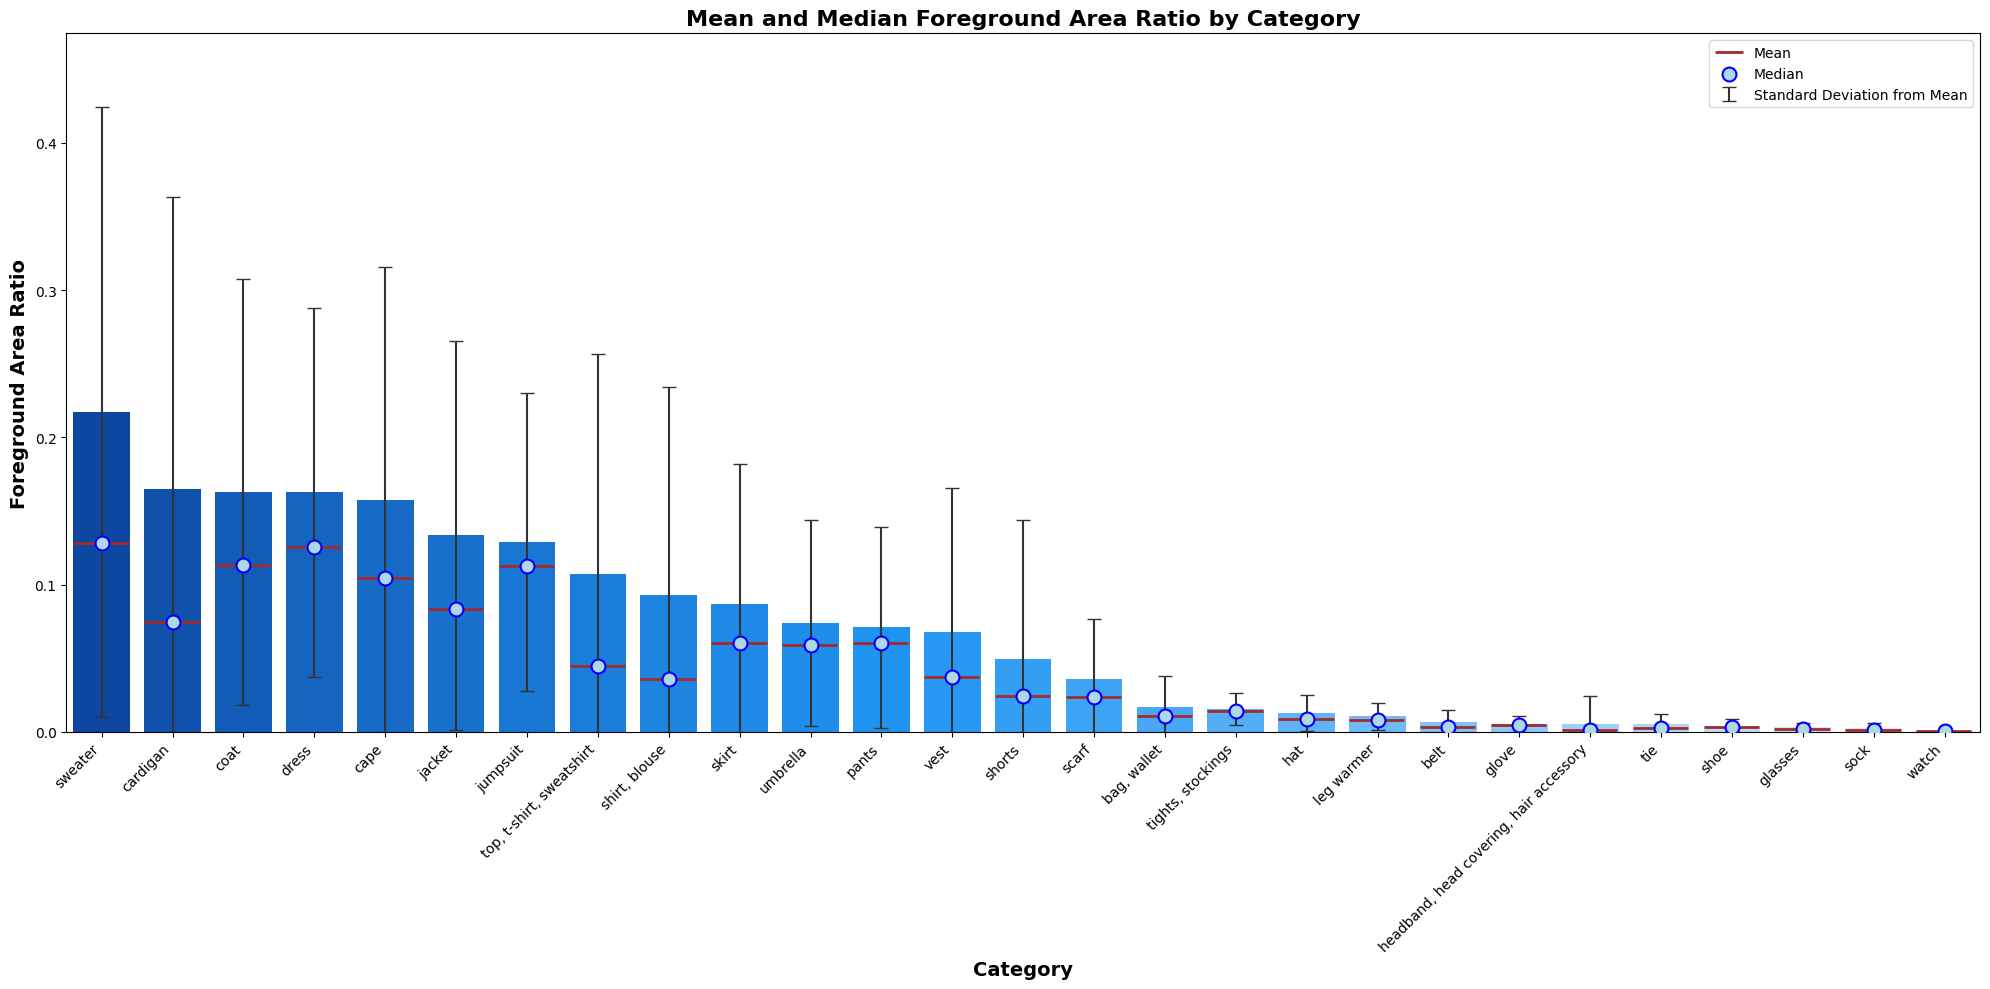

In [46]:
sorted_stats = ratio_df.sort_values(
    "foreground_area_ratio_mean", ascending=False
)

cmap = load_cmap("blue_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["foreground_area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["foreground_area_ratio_mean"],
    yerr=sorted_stats["foreground_area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["foreground_area_ratio_median"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5)

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Foreground Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Foreground Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["foreground_area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["foreground_area_ratio_mean"]
    + sorted_stats["foreground_area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_foreground_area_ratio.png")
plt.show()

### Observations  

In our analysis, we examined two ratios for each clothing item:  

1. **Overall Image Ratio**:  
     $$ \frac{\# \text{ pixels of label } j \text{ in image } i}{\# \text{ pixels in image } i} $$  
 
2. **Foreground Ratio** (excluding the background):  
   $$ \frac{\# \text{ pixels of label } j \text{ in image } i}{\# \text{ foreground pixels in image } i} $$  

From this analysis, we found that clothing items such as **sweaters, cardigans, and coats** had the highest ratio in both metrics. This indicates that these garments often dominate the image composition as well as the foreground, likely because they cover large portions of the body and are prominently displayed in fashion images.  

Interestingly, while the lowest ratio in the **overall image calculation** belonged to **shorts, shoes, and socks**, the lowest **foreground ratio** was observed for **glasses, socks, and watches**.  

This suggests that smaller accessories and footwear contribute minimally to the overall scene, but when considering only the foreground, accessories such as glasses and watches are even less prominent. This discrepancy could be explained by the fact that:  

- **Shoes and socks**, while relatively small, still appear in the lower part of the image and are often visible in full-body shots.  
- **Accessories like glasses and watches**, though present in the foreground, occupy significantly fewer pixels relative to other clothing items, making them harder to detect.  

Regarding variance, we observed that while standard deviations for the **overall image ratio** were all large and similar across categories, the **foreground ratio** exhibited more variability. Notably, **tops, t-shirts, sweatshirts, vests, and headwear (including headbands, head coverings, and hair accessories)** showed relatively high standard deviation.  

This likely arises because these categories are highly dependent on the specific image composition, pose, and framing—sometimes occupying large portions of the image (e.g., in upper-body shots) and sometimes much less (e.g., in full-body shots).  

### Hypothesis

Based on these observations, we can make the following predictions about how our clothing image segmentation model will perform across different categories:  

- **High Coverage Items (Sweaters, Cardigans, Coats):**  
  These items dominate both the image and the foreground, making them easier to segment with high accuracy. The model should perform well here due to their size and clear boundaries.  

- **Low Coverage Items in Overall Image (Shorts, Shoes, Socks):**  
  These items occupy smaller portions of the image, which might lead to challenges in detection, particularly if they are close in color to the background or blend with other clothing.  

- **Low Coverage Items in Foreground (Glasses, Socks, Watches):**  
  Since these objects occupy an even smaller percentage of the foreground, segmentation performance may suffer. Accessories like glasses and watches, in particular, might be harder to detect due to their fine details and potential occlusion by hair or sleeves.  

- **High Variability Items (Tops, T-Shirts, Sweatshirts, Vests, Headwear):**  
  The segmentation model might struggle with consistency due to their varying sizes in different image compositions. Performance could fluctuate depending on how prominently they appear in the scene.  
